# DataStreamVisualization Workshop


## 📊 Data Source Documentation

### 🔹 Source
- **File name**: `RMBR4-2_export_test.csv`  
- **Collected from**: Simulated manufacturing robot controller logs  
- **Purpose**: Used for predictive maintenance workshop (Data Streaming and Visualization)  

---

### 🔹 Structure of the Dataset
- **Time**  
  - Format: `YYYY-MM-DD HH:MM:SS`  
  - Description: Timestamp of each measurement  

- **Axis #1 ~ Axis #8**  
  - Unit: Amps (A)  
  - Description: Current readings for each of the 8 robot axes  
  - Numeric values 

---

### 🔹 Size
- Total records: ~`len(df)` rows (depends on CSV file)  
- Total columns: 9 (`Time` + 8 axis readings)  

---

### 🔹 Usage in the Workshop
1. The CSV file is read and streamed as if data is arriving in real time (every 2 seconds).  
2. Each row is:
   - Inserted into the cloud database table **`CATDC_DATA_FEED`**  
     *Axis #n -> "PART_ID:n, TYPE_ID:1, SOURCE_ID:1, FEED_ID:1, READING:Amps, TIMESTAMP:time, STATE:state "*  
      &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;(time : YYYY-MM-DD HH:MM:SS , state : RUNNING)  
     *ex) Axis #1 -> "PART_ID:1, TYPE_ID:1, SOURCE_ID:1, FEED_ID:1, READING:Amps, TIMESTAMP:time, STATE:state"*  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*Axis #6 -> "PART_ID:6, TYPE_ID:1, SOURCE_ID:1, FEED_ID:1,   READING:Amps, TIMESTAMP:time, STATE:state"*  
        
   - Plotted on a real-time line chart in Jupyter Notebook  
3. The stream simulates a live Telnet connection from a robot controller. 

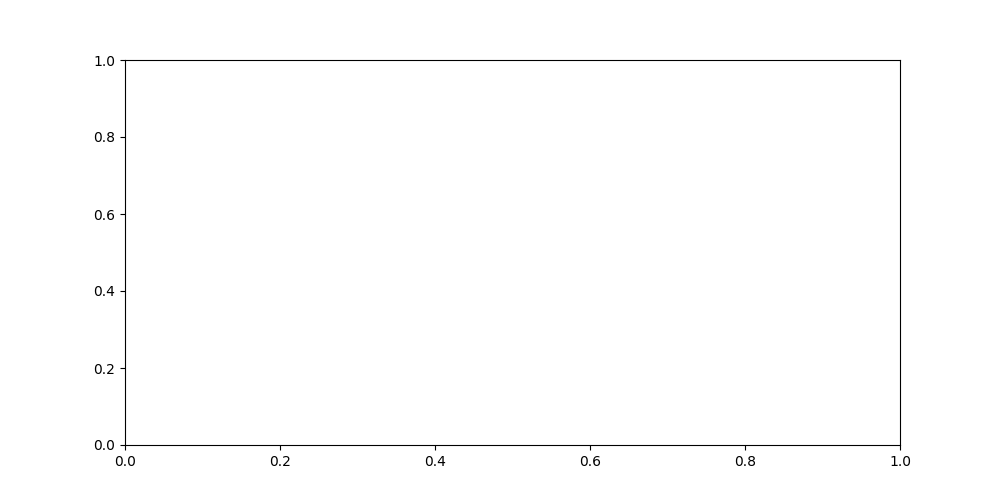

In [1]:
%matplotlib ipympl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
from scipy.interpolate import make_interp_spline
import datetime as dt
from dotenv import load_dotenv
import psycopg
import os
from IPython.display import HTML

# === Load CSV data ===
CSV_PATH = "data/RMBR4-2_export_test.csv"  # file path check
df = pd.read_csv(CSV_PATH)
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df = df.dropna(subset=['Time']).sort_values('Time').reset_index(drop=True)

axes_cols = [c for c in df.columns if c.startswith("Axis")]
df[axes_cols] = df[axes_cols].apply(pd.to_numeric, errors='coerce').fillna(0.0)

n = len(df)
WINDOW = 10  # start with 1..10, then slide window

# === Database connection setup ===
load_dotenv()
DB_URL = os.getenv("DATABASE_URL")

def run_sql(sql: str, params=None):
    try:
        with psycopg.connect(DB_URL, autocommit=True) as conn:
            with conn.cursor() as cur:
                cur.execute(sql, params or [])
                try:
                    return cur.fetchall()
                except Exception:
                    return []
    except Exception as e:
        print("DB connect/query error:", e)
        return []

def insert_data(command_string, params):
    inserted_record = run_sql(command_string, params)
    if inserted_record:
        print("Inserted:", inserted_record)

def truncate_table():
    run_sql("TRUNCATE TABLE CATDC_DATA_FEED")

# Reset table before execution
truncate_table()

# === Smoothing function (for individual line plots) ===
def smooth_lines(sub_time, sub_vals, n_points=200):
    x_num = mdates.date2num(sub_time.to_numpy())
    x_unique = np.unique(x_num)

    if x_unique.size < 2:
        x_dense = np.array([x_num[0], x_num[0] + 1e-9])
        smooth_vals = sub_vals.iloc[[0, 0]].to_numpy(dtype=float).T
    else:
        xmin, xmax = x_num.min(), x_num.max()
        x_dense = np.linspace(xmin, xmax, max(n_points, x_unique.size * 20))
        smooth_vals = []
        for col in axes_cols:
            y = sub_vals[col].to_numpy(dtype=float)
            k = min(3, len(x_unique) - 1)
            if k >= 1:
                y_on_unique = np.interp(x_unique, x_num, y)
                spline = make_interp_spline(x_unique, y_on_unique, k=k)
                y_s = spline(x_dense)
            else:
                y_s = np.interp(x_dense, x_num, y)
            smooth_vals.append(y_s)
        smooth_vals = np.vstack(smooth_vals)

    smooth_vals = np.clip(smooth_vals, -10, 100)
    x_dense_dt = mdates.num2date(x_dense)
    return x_dense_dt, smooth_vals

# === Plot and animation setup ===
fig, ax = plt.subplots(figsize=(10, 5))

def draw_frame(i):
    ax.cla()

    start = 0 if i < WINDOW else i - WINDOW + 1
    end = i + 1
    sub = df.iloc[start:end]
    sub_time = sub['Time']
    sub_vals = sub[axes_cols]

    
    sub_vals = sub[axes_cols]


    sub_axis1_value = sub_vals.iloc[-1, 0]
    sub_axis2_value = sub_vals.iloc[-1, 1]
    sub_axis3_value = sub_vals.iloc[-1, 2]
    sub_axis4_value = sub_vals.iloc[-1, 3]
    sub_axis5_value = sub_vals.iloc[-1, 4]
    sub_axis6_value = sub_vals.iloc[-1, 5]
    sub_axis7_value = sub_vals.iloc[-1, 6]
    sub_axis8_value = sub_vals.iloc[-1, 7]



    sub_time_value = sub_time.iloc[-1]

     # Example DB insert (saving only Axis #1)
    insert_data(
        """
        INSERT INTO CATDC_DATA_FEED
            (PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE) 
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        RETURNING ID, PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE
        """,
        [1, 1, 1, 1, sub_axis1_value, sub_time_value, "RUNNING"]
    )


    insert_data(
        """
        INSERT INTO CATDC_DATA_FEED
            (PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE) 
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        RETURNING ID, PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE
        """,
        [2, 1, 1, 1, sub_axis2_value, sub_time_value, "RUNNING"]
    )

    insert_data(
        """
        INSERT INTO CATDC_DATA_FEED
            (PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE) 
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        RETURNING ID, PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE
        """,
        [3, 1, 1, 1, sub_axis3_value, sub_time_value, "RUNNING"]
    )

    insert_data(
        """
        INSERT INTO CATDC_DATA_FEED
            (PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE) 
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        RETURNING ID, PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE
        """,
        [4, 1, 1, 1, sub_axis4_value, sub_time_value, "RUNNING"]
    )

    insert_data(
        """
        INSERT INTO CATDC_DATA_FEED
            (PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE) 
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        RETURNING ID, PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE
        """,
        [5, 1, 1, 1, sub_axis5_value, sub_time_value, "RUNNING"]
    )

    insert_data(
        """
        INSERT INTO CATDC_DATA_FEED
            (PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE) 
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        RETURNING ID, PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE
        """,
        [6, 1, 1, 1, sub_axis6_value, sub_time_value, "RUNNING"]
    )

    insert_data(
        """
        INSERT INTO CATDC_DATA_FEED
            (PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE) 
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        RETURNING ID, PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE
        """,
        [7, 1, 1, 1, sub_axis7_value, sub_time_value, "RUNNING"]
    )

    insert_data(
        """
        INSERT INTO CATDC_DATA_FEED
            (PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE) 
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        RETURNING ID, PART_ID, TYPE_ID, SOURCE_ID, FEED_ID, READING, TIMESTAMP, STATE
        """,
        [8, 1, 1, 1, sub_axis8_value, sub_time_value, "RUNNING"]
    )

    # Line plots (smoothed, individual axes)
    x_dense_dt, smooth_vals = smooth_lines(sub_time, sub_vals)
    for k, col in enumerate(axes_cols):
        ax.plot(x_dense_dt, smooth_vals[k], linewidth=1.6, label=col)

    left, right = sub_time.iloc[0], sub_time.iloc[-1]
    if right <= left:
        right = left + dt.timedelta(seconds=1)

    ax.set_title("Streaming smoothed lines (Notebook ver.)")
    ax.set_xlabel("Time")
    ax.set_ylabel("Amps")
    ax.set_ylim(-5, 100)
    ax.set_xlim(left, right)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left", ncol=4, fontsize=8)

    ax.xaxis.set_major_locator(mdates.SecondLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
    fig.autofmt_xdate()

# === Run animation (render directly in notebook) ===
ani = FuncAnimation(
    fig,
    draw_frame,
    frames=n,
    interval=2000,   # 2sconds interval
    repeat=False,
    cache_frame_data=False
)

display(ani)